In [27]:
from __future__ import print_function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.path.append('C:\\Users\\Mark.Rademaker\\AppData\\Local\\Programs\\Python\\Python36\\lib\\site-packages')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors
import numpy as np
import pandas as pd
import rasterio
import gdal
import os


try:
    import keras
    from keras.models import model_from_json
    from keras.optimizers import Adam
    from keras.losses import categorical_crossentropy
    import tensorflow as tf

except:
    print("Keras not found")
    
np.random.seed(42)

def my_basename(path):
    return os.path.splitext(os.path.split(path)[1])[0]

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data_GIS_extended'

In [ ]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/SQL_filtered_gbif/taxa_list.txt",header=None)
taxa.columns=["taxon"] 

###column variable names
with open(file_dir+'/data/GIS/env_stacked/variable_list.txt') as f:
      new_cols = f.readlines()

var_names=[]
for item in new_cols:
    item=item.replace("\n","")
    var_names.append(item) 

Example, recreate training and test set for Ceratotherium simum, reconstruct saved model and extract feature importance

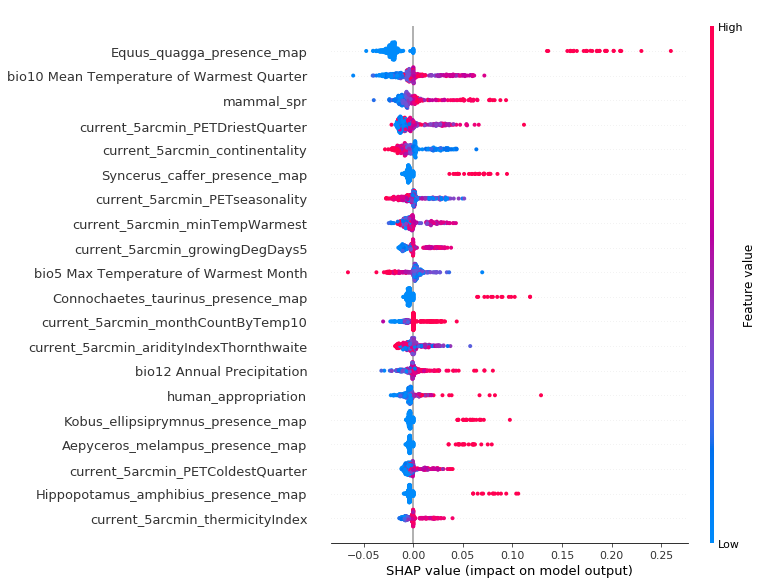

In [14]:
#open dataframe and rename columns
spec = "Ceratotherium_simum"
variables=var_names.copy()
variables.remove("%s_presence_map"%spec) #drop species own occurrences from from variable list

table = pd.read_csv(file_dir +"/data/spec_ppa_env/%s_env_dataframe.csv"%spec)
table=  table.drop('%s_presence_map'%spec,axis=1) #drop species own occurrences from features

####################################
#  filter dataframe for training   #
####################################

# drop any row with no-data values
table = table.dropna(axis=0, how="any")

# make feature vector
band_columns = [column for column in table.columns[1:186]]

X = []
y = []

for _, row in table.iterrows():
    x = row[band_columns].values
    x = x.tolist()
    x.append(row["present/pseudo_absent"])
    X.append(x)

df = pd.DataFrame(data=X, columns=band_columns + ["presence"])
df.to_csv("filtered.csv", index=None)

# extract n. of occ. and abs. samples
occ_len=int(len(df[df["presence" ]==1]))
abs_len=int(len(df[df["presence" ]==0]))


####################################
#  Numpy feature and target array  #
####################################

X = []
y = []

band_columns = [column for column in df.columns[:-1]]

for _, row in df.iterrows():
    X.append(row[band_columns].values.tolist())
    y.append([1 - row["presence"], row["presence"]])

X = np.vstack(X)
y = np.vstack(y)

####################################
#    Split training and test set   #
####################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y,random_state=42)


test_set=pd.DataFrame(X_test)
test_set.rename(columns=dict(zip(test_set.columns[0:185], variables)),inplace=True)

#shuffled_X_train=X_train.copy()
#np.random.shuffle(shuffled_X_train)
#shuffled_X_train=shuffled_X_train[:1000] # random subsample from test set for feature importance

#shuffled_X_test=X_test.copy()
#np.random.shuffle(shuffled_X_test)
#shuffled_X_test=shuffled_X_test[:1000] # random subsample from test set for feature importance


##################
# Load DNN model #
##################

json_file = open(file_dir+'/results/{}/{}_model.json'.format(spec,spec),'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights(file_dir+'/results/{}/{}_model.h5'.format(spec,spec))

#compile model
loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

######################
# Feature importance #
######################

if int(len(X_train)) > 5000:           
    explainer=shap.DeepExplainer(model,shuffled_X_train)
    test_set=pd.DataFrame(shuffled_X_test)
    test_set.rename(columns=dict(zip(test_set.columns[0:185], variables)),inplace=True)

    shap_values=explainer.shap_values(shuffled_X_test)
    fig=shap.summary_plot(shap_values[1],test_set,show=False)
    plt.savefig(file_dir+'/results/{}/_{}_feature_impact'.format(spec,spec),bbox_inches="tight")
    plt.close()

else:
    explainer=shap.DeepExplainer(loaded_model,X_train)
    shap_values=explainer.shap_values(X_test)
    fig=shap.summary_plot(shap_values[1],test_set,show=False)
    plt.show()

Now check the influence of other features on the effect of feature 2-4, that are not interpreted straightforward from the summary plot.

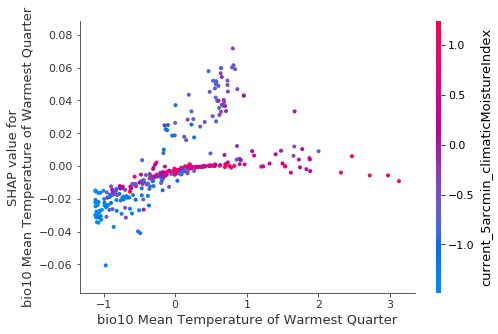

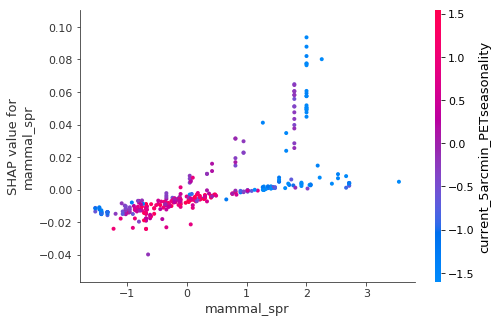

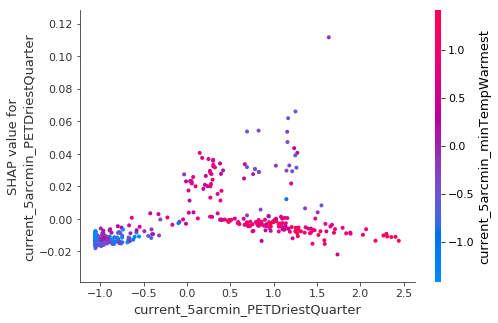

<Figure size 432x288 with 0 Axes>

In [26]:
fig=shap.dependence_plot("bio10 Mean Temperature of Warmest Quarter", shap_values[1], test_set)
plt.savefig(file_dir+'/results/{}/{}_Mean_Temp_WQ_interaction'.format(spec,spec),bbox_inches="tight")

fig=shap.dependence_plot("mammal_spr", shap_values[1], test_set)
plt.savefig(file_dir+'/results/{}/{}_mammal_spr_interaction'.format(spec,spec),bbox_inches="tight")


fig=shap.dependence_plot("current_5arcmin_PETDriestQuarter", shap_values[1], test_set)
plt.savefig(file_dir+'/results/{}/{}_PETDriestQ_interaction'.format(spec,spec),bbox_inches="tight")
